In [2]:
!pip install rasterio

  Obtaining dependency information for rasterio from https://files.pythonhosted.org/packages/fc/b9/78aedee3aa850424037aa21da482fd659200039d16e7407ffe25e07548b5/rasterio-1.4.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for affine from https://files.pythonhosted.org/packages/0b/f7/85273299ab57117850cc0a936c64151171fac4da49bc6fba0dad984a7c5f/affine-2.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for cligj>=0.5 from https://files.pythonhosted.org/packages/73/86/43fa9f15c5b9fb6e82620428827cd3c284aa933431405d1bcf5231ae3d3e/cligj-0.7.2-py3-none-any.whl.metadata
  Obtaining dependency information for click-plugins from https://files.pythonhosted.org/packages/e9/da/824b92d9942f4e472702488857914bdd50f73021efea15b4cad9aca8ecef/click_plugins-1.1.1-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/25.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.3 MB ? eta -:--:--
   -----------------------------------

In [70]:
import rasterio
import geopandas as gpd
import numpy as np
import math
from rasterio.mask import mask

In [71]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Function to parse metadata from the MTL file
def parse_mtl(mtl_file):
    metadata = {}
    with open(mtl_file, 'r') as file:
        for line in file:
            # Remove whitespace and split key-value pairs
            line = line.strip()
            if '=' in line:
                key, value = line.split(' = ')
                metadata[key] = value.strip('"')
    return metadata

# Load required metadata values for TOA conversion
def get_toa_parameters(metadata, band_number):
    Mp = float(metadata[f'REFLECTANCE_MULT_BAND_{band_number}'])
    Ap = float(metadata[f'REFLECTANCE_ADD_BAND_{band_number}'])
    sunelevation = float(metadata['SUN_ELEVATION'])
    return Mp, Ap, sunelevation

# Convert DN to TOA reflectance
def convert_to_toa(band, Mp, Ap, sine_sunelevation):
    return (Mp * band + Ap) / sine_sunelevation


Band 2 - Mp: 0.0025087, Ap: -0.007428
Band 3 - Mp: 0.002135, Ap: -0.004528
Band 4 - Mp: 0.0025841, Ap: -0.007038
Sun Elevation: 36.40292309


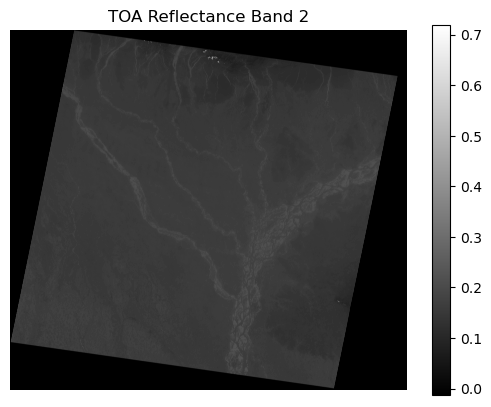

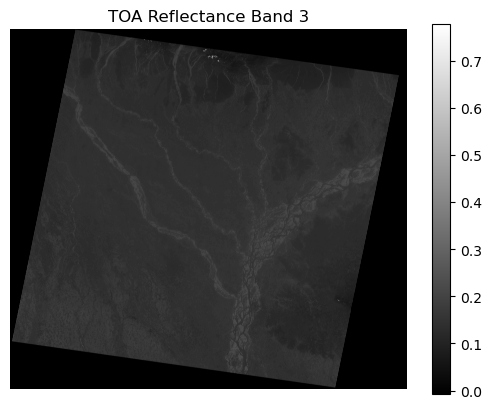

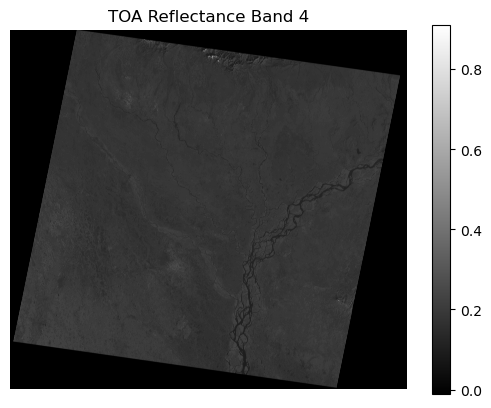

In [72]:
# Example usage
# Paths to the Landsat bands and metadata file 
band2_path = 'D:/BUET/Thesis/Landsat/2001/Landsat 42/2001_42_B2.tif'
band3_path = 'D:/BUET/Thesis/Landsat/2001/Landsat 42/2001_42_B3.tif'
band4_path = 'D:/BUET/Thesis/Landsat/2001/Landsat 42/2001_42_B4.tif'
mtl_file = 'D:/BUET/Thesis/Landsat/2001/Landsat 42/2001_42_meta.txt'  # Replace with the actual path to the metadata file

# Parse the metadata file
metadata = parse_mtl(mtl_file)

# Retrieve TOA parameters (only need to get sun elevation once)
Mp_band2, Ap_band2, sunelevation = get_toa_parameters(metadata, 2)
Mp_band3, Ap_band3, _ = get_toa_parameters(metadata, 3)  # Sun elevation is the same
Mp_band4, Ap_band4, _ = get_toa_parameters(metadata, 4)

# Print TOA parameters
print(f"Band 2 - Mp: {Mp_band2}, Ap: {Ap_band2}")
print(f"Band 3 - Mp: {Mp_band3}, Ap: {Ap_band3}")
print(f"Band 4 - Mp: {Mp_band4}, Ap: {Ap_band4}")
print(f"Sun Elevation: {sunelevation}")

# Convert sun elevation angle to radians for sine calculation
sine_sunelevation = np.sin(np.radians(sunelevation))

# Load each band and apply TOA conversion
def load_and_convert_band(band_path, Mp, Ap, sine_sunelevation):
    with rasterio.open(band_path) as src:
        band = src.read(1)  # Read the first band (the only one in this case)
        return convert_to_toa(band, Mp, Ap, sine_sunelevation)

# Convert each band
toa_band2 = load_and_convert_band(band2_path, Mp_band2, Ap_band2, sine_sunelevation)
toa_band3 = load_and_convert_band(band3_path, Mp_band3, Ap_band3, sine_sunelevation)
toa_band4 = load_and_convert_band(band4_path, Mp_band4, Ap_band4, sine_sunelevation)

# Display the TOA reflectance (optional)
def display_band(band, title):
    plt.imshow(band, cmap='gray')
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()

display_band(toa_band2, 'TOA Reflectance Band 2')
display_band(toa_band3, 'TOA Reflectance Band 3')
display_band(toa_band4, 'TOA Reflectance Band 4')

In [73]:
# Function to save the TOA-corrected band as a new .tif file
def save_band(output_path, data, profile):
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(data, 1)

# Specify the output directory
output_dir = 'D:/BUET/Thesis/ArcGIS/Radiometric Corrected Images/2001/Landsat 42'  # Replace with your desired output directory

# Save each TOA-corrected band
with rasterio.open(band2_path) as band2_src:
    profile = band2_src.profile
    profile.update(dtype=rasterio.float32)
    save_band(f'{output_dir}/2001_42_B2.tif', toa_band2.astype(rasterio.float32), profile)

with rasterio.open(band3_path) as band3_src:
    profile = band3_src.profile
    profile.update(dtype=rasterio.float32)
    save_band(f'{output_dir}/2001_42_B3.tif', toa_band3.astype(rasterio.float32), profile)
    
with rasterio.open(band4_path) as band4_src:
    profile = band4_src.profile
    profile.update(dtype=rasterio.float32)
    save_band(f'{output_dir}/2001_42_B4.tif', toa_band4.astype(rasterio.float32), profile)

print("TOA-corrected bands saved successfully.")

TOA-corrected bands saved successfully.
